# 02: Likelihood fits

In [1]:
import SMEFT19
from parscanning import GridScan
from SMEFT19.scenarios import rotBII
from SMEFT19 import likelihood_fits
import warnings
import numpy as np
import pandas as pd
from SMEFT19.plots import likelihood_plot

In [3]:
dim_min = [-0.3, -0.08, -0.025, -0.15, 0]
dim_max = [0, 0.08, 0.025, 0.15, 3.0]
coefs = ['C', 'al', 'bl', 'aq', 'bq']

In [3]:


d_ell = SMEFT19.ellipse.load('../data/ellipses/rotBII.yaml')
bf1 = d_ell['bf']

In [4]:
bf1

array([-1.24142128e-01,  3.21513287e-02, -5.42871866e-06,  1.62377880e-02,
        8.55621324e-01])

## Plotting

In [4]:
def read_meshgrid(par_x, par_y):
    index_x = coefs.index(par_x)
    index_y = coefs.index(par_y)
    xcoords = np.linspace(dim_min[index_x], dim_max[index_x], 50)
    ycoords = np.linspace(dim_min[index_y], dim_max[index_y], 50)
    d = {}
    d[r'$R_{K^{(*)}}$'] = pd.read_csv(f"../data/likelihood/likelihood_rotBII_{par_x}{par_y}_RK.dat", sep = '\t', header=None).values.T
    d[r'$R_{D^{(*)}}$'] = pd.read_csv(f"../data/likelihood/likelihood_rotBII_{par_x}{par_y}_RD.dat", sep = '\t', header=None).values.T
    d['LFV'] = pd.read_csv(f"../data/likelihood/likelihood_rotBII_{par_x}{par_y}_LFV.dat", sep = '\t', header=None).values.T
    d['Global'] = pd.read_csv(f"../data/likelihood/likelihood_rotBII_{par_x}{par_y}.dat", sep = '\t', header=None).values.T
    return (xcoords, ycoords, d)

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import scipy
import flavio
from flavio.statistics.functions import delta_chi2

def listpoint(x):
    r'''
If passed a single 2-tuple (representing one point), it returns a list containing the tuple.
If passed more than 1 2-tuple (representing several points), returns the argument.
TODO: Rewrite in python 3.10 using match&case syntax.
    '''
    if len(x) == 2:
        if len(np.array(x).flat) == 2:
            return [x,]
        else:
            return x
    else:
        return x

def likelihood_plot2(grid, xmin, xmax, ymin, ymax, axlabels, fout=None, locleg=0, n_sigma=(1, 2),
                    colors=None, styles=None, widths=None, ticks=0.5, bf=None):
    r'''
Plots a contour plot of the log-likelihood of the fit.

:Arguments:

    - grid\: List containing the x coordinates, y corrdinates
      and a dictionary for the likelihood values in the grid.
    - xmin\: Minimum value of the `x` coordinate.
    - xmax\: Maximum value of the `x` coordinate.
    - ymin\: Minimum value of the `y` coordinate.
    - ymax\: Maximum value of the `y` coordinate.
    - axlabels\: List containing two strings to label the `x` and `y` axes.
    - [fout\: Path to the files where the plots will be saved.
      Two files are created, one `.pdf` and one `.pgf` (to use in TeX).
      Extensions are added automatically.]
    - [locleg\: Position of the legend of the plot, using `matplotlib`'s syntaxis.
      Default=0 (best position).]
    - [n_sigma\: List containing the significance (in sigmas) of each contour. Default = (1,2).]
    - [colors\: List with the colors of each contour. Default: flavio palette.]
    - [styles\: List with the linestyles of each contour. Default: All solid.]
    - [widths\: List with the linewidths of each contour. Default: All 1pt.]
    - [ticks\: Interval between ticks in both axes. Default:0.5]
    - [bf\: Coordinates of the best fit point(s). It can be `None` (no point marked)
      or a list containing two floats (one point marked). Default: `None`.]
    '''

    fig = plt.figure(figsize=(6, 6))
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    nfits = len(grid[2])
    if colors is None:
        _cols = [i%9 for i in range(nfits)]
    else:
        _cols = colors
    if styles is None:
        lstyle = ['solid',]*nfits
    else:
        lstyle = styles
    if widths is None:
        lwidths = [1,]*nfits
    else:
        lwidths = widths
    x = grid[0]
    y = grid[1]
    zl = grid[2]
    handles = []
    for i, z in enumerate(zl.values()):
        chi = -2*(z.T-np.max(z))
        # get the correct values for 2D confidence/credibility contours for n sigma
        if isinstance(n_sigma, float) or isinstance(n_sigma, int):
            levels = [delta_chi2(n_sigma, dof=2)]
        else:
            levels = [delta_chi2(n, dof=2) for n in n_sigma]
        hatch_contour(x=x, y=y, z=chi, levels=levels, col=_cols[i], label=list(zl.keys())[i],
                      interpolation_factor=5, hatched=False,
                      contour_args={'linestyles':lstyle[i], 'linewidths':lwidths[i]})
        proxy_patch = plt.Line2D([0], [0], color=flavio.plots.colors.set1[_cols[i]], label=list(zl.keys())[i])
        handles.append(proxy_patch)
        if bf is not None:
            for p in listpoint(bf):
                plt.scatter(*p, marker='x', color='black')
    plt.xlabel(axlabels[0], fontsize=18)
    plt.ylabel(axlabels[1], fontsize=18)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    ax = fig.gca()
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    if isinstance(ticks, float):
        xticks = ticks
        yticks = ticks
    else:
        xticks = ticks[0]
        yticks = ticks[1]
    ax.xaxis.set_ticks(np.arange(xmin, xmax+1e-5, xticks))
    ax.yaxis.set_ticks(np.arange(ymin, ymax+1e-5, yticks))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(handles=handles, loc=locleg, fontsize=16)
    plt.tight_layout(pad=0.5)
    if fout is not None:
        fig.savefig(fout+'.pdf')
        fig.savefig(fout+'.pgf')

def hatch_contour(x, y, z, levels, interpolation_factor=1, interpolation_order=2, col=0,
                  label=None, hatched=True, contour_args=None, contourf_args=None):
    r"""
Plots coloured and hatched confidence contours (or bands) given numerical
input arrays.Based on the `flavio` function

:Arguments:

    - x, y\: 2D arrays containg x and y values as returned by numpy.meshgrid
    - z\: value of the function to plot. 2D array in the same shape as `x` and
      `y`. The lowest value of the function should be 0 (i.e. the best fit point).
    - levels\: list of function values where to draw the contours. They should
      be positive and in ascending order.
    - [interpolation factor\:: in between the points on the grid,
      the functioncan be interpolated to get smoother contours.
      This parameter sets the number of subdivisions (default: 1, i.e. no
      interpolation). It should be larger than 1.]
    - [col\: number between 0 and 9 to choose the color of the plot
      from a predefined palette.]
    - [label\: label that will be added to a legend created with `maplotlib.pyplot.legend()`.]
    - [contour_args\: dictionary of additional options that will be passed to
      `matplotlib.pyplot.contour()` (that draws the contour lines).]
    - [contourf_args\: dictionary of additional options that will be passed to
      `matplotlib.pyplot.contourf()` (that paints the contour filling).]
    """
    contour_args = contour_args or {}
    contourf_args = contour_args or {}
    if interpolation_factor > 1:
        x = scipy.ndimage.zoom(x, zoom=interpolation_factor, order=1)
        y = scipy.ndimage.zoom(y, zoom=interpolation_factor, order=1)
        z = scipy.ndimage.zoom(z, zoom=interpolation_factor, order=interpolation_order)
    if isinstance(col, int):
        _contour_args = {}
        _contourf_args = {}
        _contour_args['colors'] = [flavio.plots.colors.set1[col]]
        _contour_args['linewidths'] = 1.2
        N = len(levels)
        _contourf_args['colors'] = [flavio.plots.colors.pastel[col] +
                                    (max(1-n/(N+1), 0),) for n in range(1, N+1)]
    else:
        _contour_args = {}
        _contourf_args = {}
        _contour_args['colors'] = [darken_color(matplotlib.colors.to_rgb(col), 0.7)]
        _contour_args['linewidths'] = 1.2
        N = len(levels)
        _contourf_args['colors'] = [matplotlib.colors.to_rgb(col) +
                                    (max(1-n/(N+1), 0),) for n in range(1, N+1)]

    if hatched:
        hl = []
        for i in range(0, N):
            hl.append(hatches[col]*(N-i))
        hl.append(None)
        _contourf_args['hatches'] = hl
    _contour_args['linestyles'] = 'solid'
    _contour_args.update(contour_args)
    _contourf_args.update(contourf_args)
    # for the filling, need to add zero contour
    levelsf = [np.min(z)] + list(levels)
    ax = plt.gca()
    CF = ax.contourf(x, y, z, levels=levelsf, **_contourf_args)
    CS = ax.contour(x, y, z, levels=levels, **_contour_args)
    return (CS, CF)

linewidths is ignored by contourf


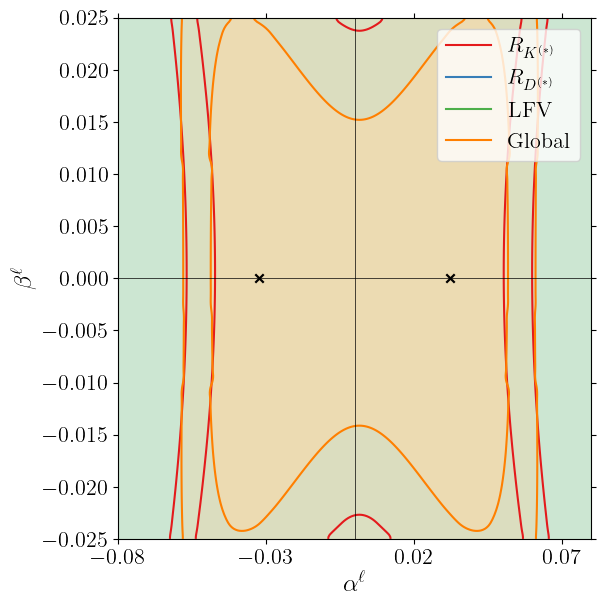

In [42]:
likelihood_plot2(read_meshgrid('al', 'bl'),
                -0.08, 0.08, -0.025, 0.025, [r'$\alpha^\ell$', r'$\beta^\ell$'], locleg='upper right',
                colors=[0,1,2,4], bf=([bf1[1], bf1[2]], [-bf1[1], bf1[2]]),
                widths=[1.5,]*5, ticks=(0.05, 0.005),  fout='../data/plots/alphabeta_l')

linewidths is ignored by contourf


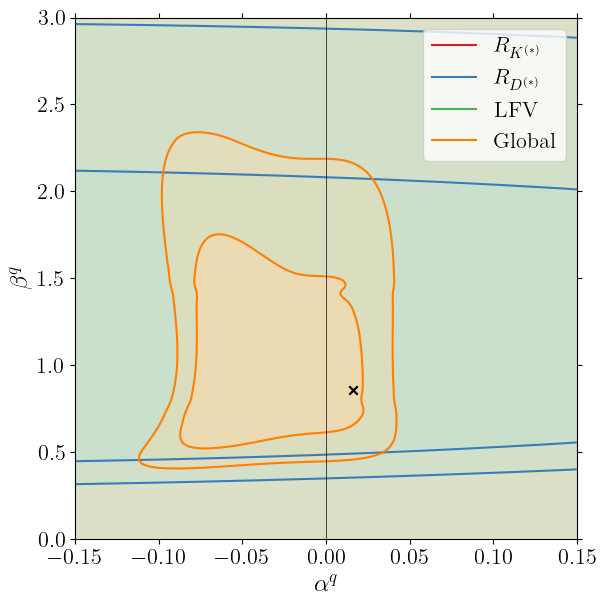

In [43]:
likelihood_plot2(read_meshgrid('aq', 'bq'),
                -0.15, 0.15, 0, 3., [r'$\alpha^q$', r'$\beta^q$'], locleg='upper right', ticks=(0.05, 0.5),
                colors=[0,1,2,4], bf=[bf1[3], bf1[4]], widths=[1.5,]*5, fout='../data/plots/alphabeta_q')

## Scenario III

In [2]:
dim_min = [-0.3, -0.3, 0]
dim_max = [0, 0.0, 3.0]
coefs = ['C1', 'C3', 'bq']

In [38]:
d_ell = SMEFT19.ellipse.load('../data/ellipses/rotBIII.yaml')
bf3 = d_ell['bf']

d_ell_2 = SMEFT19.ellipse.load('../data/ellipses/rotBIII_2.yaml')
bf3_2 = d_ell_2['bf']

In [10]:
def read_meshgrid(par_x, par_y):
    index_x = coefs.index(par_x)
    index_y = coefs.index(par_y)
    xcoords = np.linspace(dim_min[index_x], dim_max[index_x], 50)
    ycoords = np.linspace(dim_min[index_y], dim_max[index_y], 50)
    d = {}
    #d[r'$R_{K^{(*)}}$'] = pd.read_csv(f"../data/likelihood/likelihood_rotBIII_{par_x}{par_y}_RK.dat", sep = '\t', header=None).values.T
    d[r'LFU $b\to c \ell \nu$'] = pd.read_csv(f"../data/likelihood/likelihood_rotBIII_{par_x}{par_y}_RD.dat", sep = '\t', header=None).values.T
    #d['LFV'] = pd.read_csv(f"../data/likelihood/likelihood_rotBII_{par_x}{par_y}_LFV.dat", sep = '\t', header=None).values.T
    d[r'$b\to q \nu \nu$'] = pd.read_csv(f"../data/likelihood/likelihood_rotBIII_{par_x}{par_y}_bqnunu.dat", sep = '\t', header=None).values.T
    d['Global'] = pd.read_csv(f"../data/likelihood/likelihood_rotBIII_{par_x}{par_y}.dat", sep = '\t', header=None).values.T
    return (xcoords, ycoords, d)

linewidths is ignored by contourf


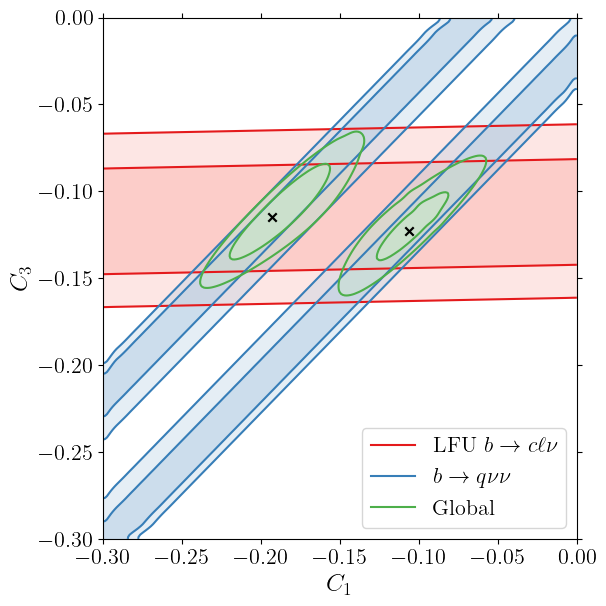

In [39]:
likelihood_plot2(read_meshgrid('C1', 'C3'),
                -0.3, 0.0, -0.3, 0.0, [r'$C_1$', r'$C_3$'], locleg='lower right',
                colors=[0,1,2], bf=([bf3[0], bf3[1]], [bf3_2[0], bf3_2[1]]),
                widths=[1.5,]*5, ticks=(0.05, 0.05),  fout='../data/plots/scIII_C1C3')

linewidths is ignored by contourf


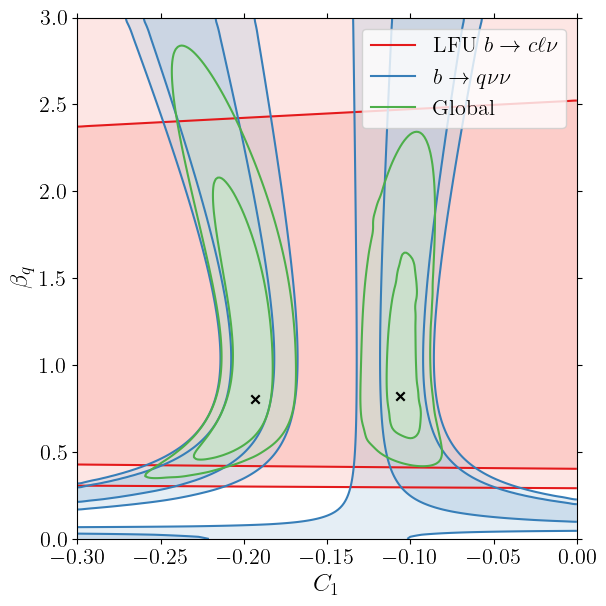

In [40]:
likelihood_plot2(read_meshgrid('C1', 'bq'),
                -0.3, 0.0, 0.0, 3.0, [r'$C_1$', r'$\beta_q$'], locleg='upper right',
                colors=[0,1,2], bf=([bf3[0], bf3[2]], [bf3_2[0], bf3_2[2]]),
                widths=[1.5,]*5, ticks=(0.05, 0.5),  fout='../data/plots/scIII_C1bq')

linewidths is ignored by contourf


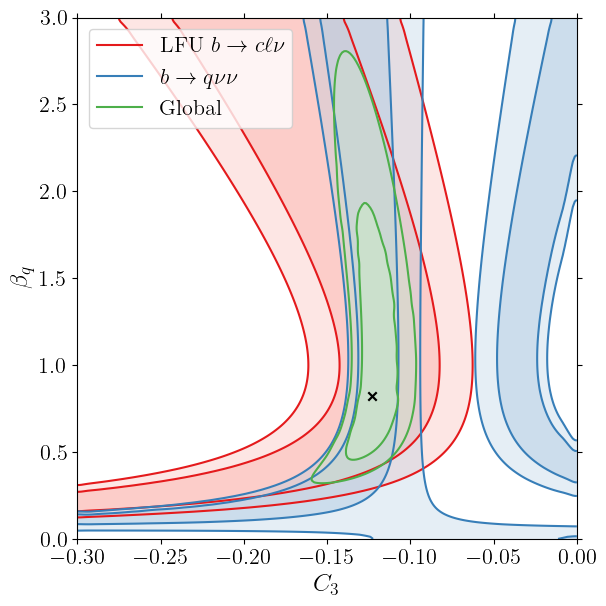

In [43]:
likelihood_plot2(read_meshgrid('C3', 'bq'),
                -0.3, 0.0, 0.0, 3.0, [r'$C_3$', r'$\beta_q$'], locleg='upper left',
                colors=[0,1,2], bf=([bf3[1], bf3[2]]),
                widths=[1.5,]*5, ticks=(0.05, 0.5),  fout='../data/plots/scIII_C3bq')